# Sawtooth extraction

This notebook defines a function `ST_detector` that takes a shot number and locates the sawtooth crashes within this shot.
Use it by adding the following to the top of your notebook:

```
%run ./sawtooth_peaks_detection.ipynb
```

You can then run it like:
```
sawteeth = ST_detector(18273)
```

The `sawteeth` object is a `SawtoothCrashes` object. It has three fields:

    - shot_number (integer)
    - times (numpy float array of sawtooth crash times in milliseconds)
    - amplitudes (numpy float array of sawtooth crash amplitudes)

You can have the result be automatically pickled by passing a save path to `ST_detector`.

In [1]:
# Author: Magne Lauritzen, mag.lauritzen@gmail.com
# -- use this line at the beginning of your notebook to turn on interactive plots
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # plotting library
from matplotlib import colors
import numpy as np  # work with numeric arrays without labeled axes
import xarray as xr  # work with arrays with labeled axes
import scipy.signal as dsp  # xarray signal filtering etc.
import xrscipy.signal as xdsp 
import scipy as sps
from cdb_extras import xarray_support as cdbxr  # access to COMPASS Database (CDB)
import pickle
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Union
plt.rcParams.update({'font.size': 14})

In [3]:
@dataclass
class SawtoothCrashes:
    """
    Dataclass for holding sawtooth data. 
    To access its properties:
    ```
            times = SawtoothCrashes.times
    ```
    """
    shot_number: int
    times: np.ndarray
    amplitudes: np.ndarray

In [4]:
def _get_plot():
    fig, ax = plt.subplots(figsize=(6.5,5.5))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xlabel('time [ms]')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    return fig, ax

def _add_legend(ax):
    ax.legend(loc="upper right", fontsize="12")
    

In [5]:
def _get_data(shot_nr: int, is_core: bool, plot: bool = False, f_high: float = 1.5, f_low: float = 0.05):
    """
    Takes a shot number and returns the bandpass-filtered SXR dataset from this shot as well as its spectrum and the sum of 
    the energy content of the spectrum along the frequency axis.
    
    The SXR dataset used when is_core is True is SXR_A_25. When is_core is False, SXR_A_32 is used instead.
    """
    shot = cdbxr.Shot(shot_nr)  # dict-like accessor to all signals measured in a given shot\
    src = 'SXR_A_25' if is_core else 'SXR_A_32'
    SXR = -1*shot[src]
    SXR -= np.mean(SXR[:25])
    fs = 1/np.nanmean(np.diff(SXR.coords['time'][:1000]))
    
    # Bandpass the SXR signal to get rid of high frequency noise and low frequency variation
    SXR_smoothed = xdsp.bandpass(SXR, f_high=f_high, f_low=f_low)
    SXR_smoothed_diff = xr.zeros_like(SXR_smoothed)
    SXR_smoothed_diff.values = np.gradient(SXR_smoothed.data) * fs

    spec = xdsp.spectrogram(SXR_smoothed, nperseg=2**16, fs=fs)
    #selected_freqs = freqs[(freqs >= 0) & (freqs <= 2)]
    #selected_freqs = np.array(selected_freqs)
    #spec = spec[selected_freqs, :]
    spec = spec.sel(frequency=slice(0, 2))
    
    sum_spec = np.sum(np.abs(spec.data), axis=0)
    
    if plot:
        ss = 10
        t = SXR.coords['time'][::ss]
        norm = colors.LogNorm(*np.percentile(spec.data, (2, 98)))
        spec.plot(norm=norm) 
        
        fig, ax = _get_plot()
        ax.plot(t, SXR[::ss], label='Raw SXR')
        ax.set_ylabel('Soft X-rays [W]')
        _add_legend(ax)
        ax.set_title(f"Shot #{shot_nr} - {src}")

        fig, ax = _get_plot()
        ax.plot(t, SXR_smoothed[::ss], label=f'Bandpassed SXR', c='C2')
        ax.set_ylabel('Soft X-rays [W]')
        _add_legend(ax)
        ax.set_title(f"Shot #{shot_nr} - {src}")
    return SXR_smoothed, SXR_smoothed_diff, spec, sum_spec
    

In [6]:
def _find_peaks(SXR_smoothed_diff: np.ndarray, spec: np.ndarray, sum_spec: np.ndarray, is_core: bool, shot_nr:int, 
                with_plots: bool = False):
    """
    Locates peaks in the differentiated SXR data. Discards points that appear to be below the noise floor or in regions where 
    there is not much spectrum energy content.
    """
    # Estimate noise floor
    noise_floor = np.percentile(np.abs(SXR_smoothed_diff.data), 90)
    # Find peak indeces
    if is_core:
        scaler = -1
    else:
        scaler = 1
        
    peaks_ind, _ = sps.signal.find_peaks(scaler*SXR_smoothed_diff.values, height=noise_floor, distance=3E3)
    
    # Mask peaks below 5% of the maximum energy content of the spectrogram
    sum_spec_threshold = 0.05*np.max(sum_spec)
    sum_spec_interpolated = np.interp(SXR_smoothed_diff.coords['time'], spec.coords['time'], sum_spec)
    sum_spec_threshold_mask = sum_spec_interpolated[peaks_ind] > sum_spec_threshold
    peaks_ind = peaks_ind[sum_spec_threshold_mask]
    
    # Get x values of peaks
    peak_x = SXR_smoothed_diff.coords['time'].data[peaks_ind]
    
    if with_plots:
        ss = 10
        t = SXR_smoothed_diff.coords['time'][::ss]
        
        fig, ax = _get_plot()
        ax.plot(t, SXR_smoothed_diff[::ss], label="Differentiated SXR", zorder=1)
        ax.plot(t, np.full(len(t), scaler*noise_floor) , label="Estimated noise floor", zorder=1, c='red')
        ax.scatter(peak_x, SXR_smoothed_diff[peaks_ind], c='Salmon', label="Detected peaks", zorder=1)
        ax.fill_between(t, scaler*noise_floor, where=sum_spec_interpolated[::ss] > sum_spec_threshold, 
                         facecolor='Salmon', alpha=.5, zorder=2, label="ST region")
        _add_legend(ax)
        ax.set_ylabel('Soft X-rays [W/s]')
        ax.set_title(f'Shot {shot_nr} - Peak detection')

    return peaks_ind, peak_x
    

In [7]:
def _get_smallest_TS_distance(peak_x: np.ndarray):
    """
    For each TS position in peak_x, calculates the distance to the nearest ST crash.
    """
    peak_x_padded = np.pad(peak_x, 1, 'edge')
    forward_diff = np.abs(peak_x_padded[:-1] - peak_x_padded[1:])[1:]
    forward_diff[-1] = np.inf
    
    backwards_diff = np.abs(peak_x_padded[1:] - peak_x_padded[:-1])[:-1]
    backwards_diff[0] = np.inf
    
    min_diff = np.min(np.vstack((forward_diff, backwards_diff)), axis=0)
    return min_diff
    

In [8]:
def _get_ST_magnitudes(SXR_smoothed: np.ndarray, peaks_ind: np.ndarray, peak_x: np.ndarray, is_core: bool, shot_nr: int, 
                       with_plots: bool = False):
    """
    Calculates the magnitude of each sawtooth crash. 
    """
    smallest_TS_distance = _get_smallest_TS_distance(peak_x)
    crash_min=np.zeros(len(peaks_ind))
    crash_max=np.zeros(len(peaks_ind))
    SXR_idx=np.zeros(len(peaks_ind), dtype=int)
    SXR_x=np.zeros(len(peaks_ind))
    
    if is_core:
        scaler = 1
    else:
        scaler = -1
    
    for i, peak_i in enumerate(peaks_ind):
        ind_window = 0.25 * 2000 * smallest_TS_distance[i]
        subset = scaler*SXR_smoothed.data[int(peak_i-round(ind_window)):int(peak_i+round(ind_window))]
        subset_argmax = np.argmax(subset)
        
        SXR_idx[i] = subset_argmax + int(peak_i-round(ind_window))
        SXR_x[i] = SXR_smoothed.coords['time'][SXR_idx[i]]
        crash_max[i] = subset[subset_argmax]
        crash_min[i] = np.min(subset)
    crash_amp = crash_max-crash_min
        
        
    if with_plots:
        ss = 10
        t = SXR_smoothed.coords['time'][::ss]
        fig, ax = _get_plot()
        ax.plot(t, SXR_smoothed[::ss], label="Bandpassed SXR", zorder=1, c='C2')
        ax.scatter(SXR_x, scaler*crash_max, c='Salmon', label="Detected sawtooths", zorder=1)
        ax.vlines(SXR_x, scaler*crash_min, scaler*crash_max, label="Sawtooth amplitude")
        _add_legend(ax)
        ax.set_ylabel('Soft X-rays [W]')
        ax.set_title(f"Shot #{shot_nr} - Sawtooth detection")
    return crash_amp
        

In [9]:
def _save_results(save_path: Optional[Path], shot_nr: int, peak_x: np.ndarray, crash_amp: np.ndarray):
    """
    Builds a SawtoothCrashes instance with the sawtooth data. Pickles it and saves it as `{shot_nr}_st.bin` if save_path is 
    not None.
    """
    sawtooth_data = SawtoothCrashes(shot_number=shot_nr, times=peak_x, amplitudes=crash_amp)
    if save_path is not None:
        save_path.mkdir(exist_ok=True)

        filename = f"{shot_nr}_st.bin"
        filepath = save_path / Path(filename)
        with open(filepath, 'wb') as fp:
            pickle.dump(sawtooth_data, fp)
    return sawtooth_data

In [10]:
def ST_detector(shot_nr: int, is_core: bool = True, with_plots: bool = False, 
                save_path: Optional[Union[Path, str]] = None):
    """
    Locates sawteeth and their amplitudes in a COMPASS shot.
    
    Arguments:
        - shot_nr    : The COMPASS shot number
        - is_core    : Whether to look for sawteeth in the core of the plasma (True) or the edge of the plasma (False)
        - with_plots : Whether to create plots that show the behaviour of the detection algorithm (good for debugging)
        - save_path  : Location where to save the results. Turn off saving by passing save_path=None.
    """
    save_path = Path(save_path) if save_path is not None else save_path
    # Fetch data
    SXR_smoothed, SXR_smoothed_diff, spec, sum_spec = _get_data(shot_nr, is_core, with_plots)
    
    # Locate crashes
    peaks_ind, peak_x = _find_peaks(SXR_smoothed_diff, spec, sum_spec, is_core, shot_nr, with_plots)
    
    # Get crash magnitudes
    peak_magnitudes = _get_ST_magnitudes(SXR_smoothed, peaks_ind, peak_x, is_core, shot_nr, with_plots)

    # Save
    return _save_results(save_path, shot_nr, peak_x, peak_magnitudes)

SawtoothCrashes(shot_number=18273, times=array([1082.579 , 1086.947 , 1091.9915, 1098.0705, 1104.6805, 1111.5455,
       1118.776 , 1125.994 , 1133.2515, 1140.547 , 1147.699 , 1154.8075,
       1162.3205, 1169.2805, 1176.298 , 1183.323 , 1188.844 , 1193.066 ,
       1196.3215, 1199.4165, 1201.856 ]), amplitudes=array([8.61247838e-08, 1.45313622e-07, 1.89463625e-07, 3.44230164e-07,
       3.87669272e-07, 3.52249515e-07, 3.44468264e-07, 3.63221216e-07,
       5.07296140e-07, 6.54221746e-07, 6.04793069e-07, 4.51928154e-07,
       4.11753864e-07, 3.58449108e-07, 3.61600043e-07, 3.45334037e-07,
       3.07741132e-07, 2.06861304e-07, 1.12708892e-07, 1.18326806e-07,
       8.95285903e-08]))

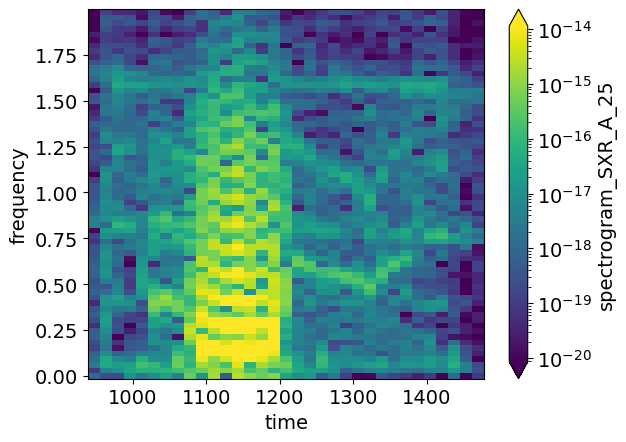

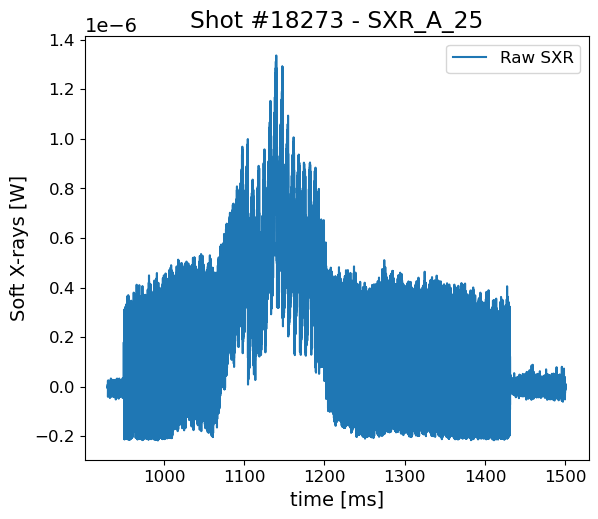

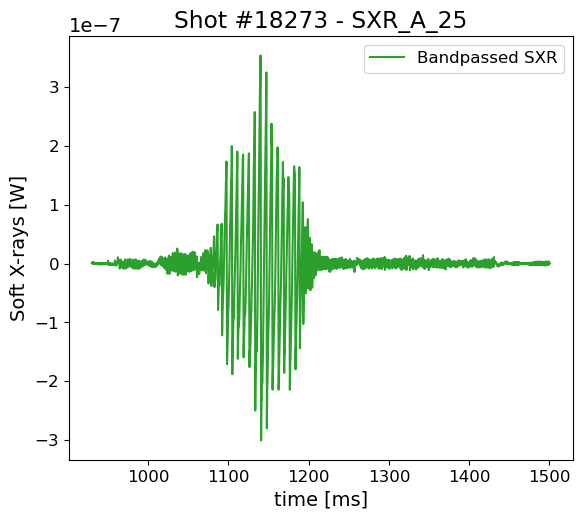

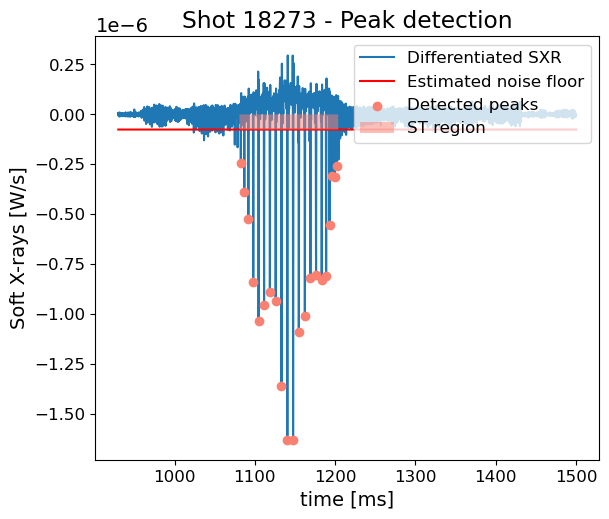

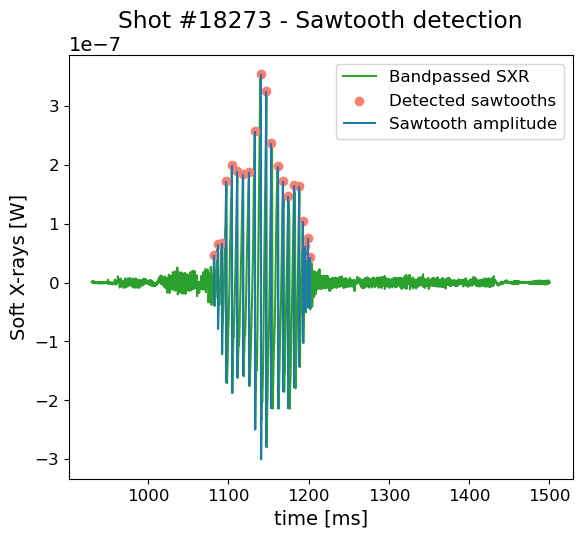

In [11]:
# Uncomment the following line to test the algorithm
ST_detector(18273, with_plots=True)